<a href="https://colab.research.google.com/github/dhanmoti/ml-exercise/blob/smu-fnce685-project/SMU_FNCE685_G2_PD_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries (uncomment in Google Colab)
#!pip install xgboost catboost imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE


In [ ]:

# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/dhanmoti/ml-exercise/main/credit_risk_dataset.csv")
df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
# drop Null values
df = df.dropna()

# Check for missing data
missing_values = df.isnull()
missing_values

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,False,False,False,False,False,False,False,False,False,False,False,False
32577,False,False,False,False,False,False,False,False,False,False,False,False
32578,False,False,False,False,False,False,False,False,False,False,False,False
32579,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Encode categorical variables
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
# Handle outliers using IQR method
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

numeric_columns = ['person_income', 'loan_amnt', 'loan_int_rate']
df = remove_outliers(df, numeric_columns)

In [ ]:
# Feature selection
X = df.drop(columns=['loan_status'])  # Features
y = df['loan_status']  # Target

In [ ]:
# Preprocess data

# Scale numerical features
scaler = StandardScaler()
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_proba, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Define the thresholds to highlight
    desired_thresholds = [0.3, 0.5, 0.7]

    # Function to find the closest threshold
    def find_closest_threshold(thresholds, desired_thresh):
        idx = np.argmin(np.abs(thresholds - desired_thresh))
        return idx

    # Highlight specific threshold points
    for thresh in desired_thresholds:
        idx = find_closest_threshold(thresholds, thresh)
        plt.scatter(fpr[idx], tpr[idx], label=f'Threshold ≈ {thresholds[idx]:.2f}', marker='o')

    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(verbose=0)
}


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      6162
           1       0.78      0.77      0.78      6157

    accuracy                           0.78     12319
   macro avg       0.78      0.78      0.78     12319
weighted avg       0.78      0.78      0.78     12319



<Figure size 800x600 with 0 Axes>

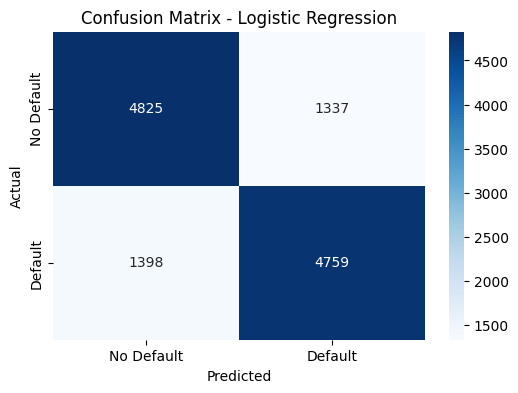

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:14:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Performance:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      6162
           1       0.99      0.92      0.95      6157

    accuracy                           0.95     12319
   macro avg       0.96      0.95      0.95     12319
weighted avg       0.96      0.95      0.95     12319



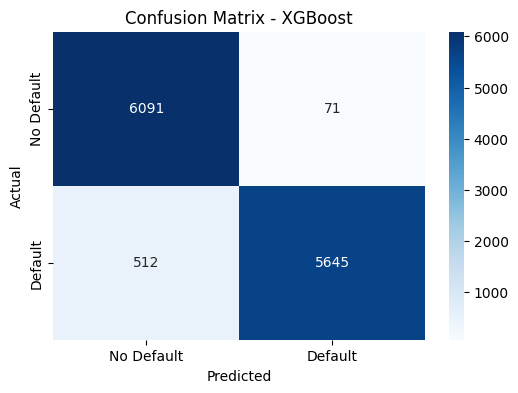


CatBoost Performance:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      6162
           1       0.99      0.91      0.95      6157

    accuracy                           0.95     12319
   macro avg       0.96      0.95      0.95     12319
weighted avg       0.96      0.95      0.95     12319



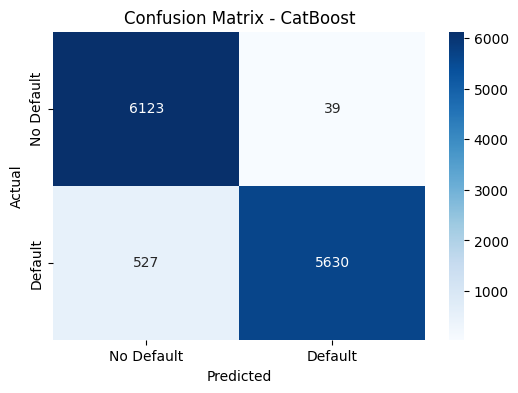

In [ ]:
# Train and evaluate models
results = {}
plt.figure(figsize=(8, 6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_pred_proba),
        "Train Accuracy": accuracy_score(y_train, model.predict(X_train)),
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Train AUC": roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
        "Test AUC": roc_auc_score(y_test, y_pred_proba)

    }

    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # Call function to plot ROC curve
    # plot_roc_curve(y_test, y_pred_proba, name)

In [ ]:
# Convert results to DataFrame for easy visualization
results_df = pd.DataFrame(results).T
print("\nModel Performance Summary:")
print(results_df)


Model Performance Summary:
                     Accuracy  Precision    Recall  F1-score       AUC  \
Logistic Regression  0.777985   0.780676  0.772941  0.776789  0.851366   
XGBoost              0.952675   0.987579  0.916843  0.950897  0.983560   
CatBoost             0.954055   0.993120  0.914406  0.952139  0.983447   

                     Train Accuracy  Test Accuracy  Train AUC  Test AUC  
Logistic Regression        0.781338       0.777985   0.854514  0.851366  
XGBoost                    0.974672       0.952675   0.998122  0.983560  
CatBoost                   0.966461       0.954055   0.994857  0.983447  


Overfitting vs. Underfitting Analysis
The models have been trained and evaluated using Accuracy and AUC-ROC on both training and test sets. Let's analyze each model:

1️⃣ Logistic Regression
Train Accuracy: 78.13%
Test Accuracy: 77.80%
Train AUC: 85.45%
Test AUC: 85.14%
✅ Analysis:
The training and test performance are very close.
No significant gap → Good generalization, No overfitting.
However, the accuracy is relatively low, suggesting possible underfitting.
📌 Conclusion: Slightly underfitted (could improve by adding more features or using a more flexible model).

2️⃣ XGBoost
Train Accuracy: 97.47%
Test Accuracy: 95.27%
Train AUC: 99.81%
Test AUC: 98.36%
⚠️ Analysis:
High accuracy on both training and test sets.
Train-Test gap: ~2% in Accuracy, ~1.5% in AUC.
This suggests some level of overfitting, though not extreme.
📌 Conclusion: Mild overfitting but still acceptable. Regularization (like max_depth, min_child_weight, or learning_rate) can reduce overfitting.

3️⃣ CatBoost
Train Accuracy: 96.65%
Test Accuracy: 95.41%
Train AUC: 99.48%
Test AUC: 98.34%
⚠️ Analysis:
Train-Test gap: ~1.2% in Accuracy, ~1.1% in AUC.
Similar to XGBoost, but slightly better generalization.
📌 Conclusion: Mild overfitting, but acceptable. Could benefit from regularization or slight reduction in model complexity.

Final Verdict
✅ Logistic Regression: Slightly underfitted (low accuracy, needs more complexity or features).
⚠️ XGBoost & CatBoost: Mild overfitting, but still generalizing well. Regularization can help.

Next Steps:

For Logistic Regression: Try Polynomial Features, Feature Engineering, or a more complex model.
For XGBoost & CatBoost: Adjust regularization (lambda, max_depth, learning_rate) to improve generalization.
Would you like me to suggest specific hyperparameter tuning settings for these models? 🚀